<a href="https://colab.research.google.com/github/shubham-kanodia/pose-tracking/blob/main/Pose_Tracker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python -m pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 46.2 MB/s eta 0:00:00


In [ ]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

In [ ]:
model_path = './pose_landmarker.task'

In [ ]:
!wget -O pose_landmarker.task -q https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_heavy/float16/1/pose_landmarker_heavy.task

In [ ]:
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np


def draw_landmarks_on_image(rgb_image, pose_landmarks_list):
  annotated_image = np.copy(rgb_image)

  # Loop through the detected poses to visualize.
  for idx in range(len(pose_landmarks_list)):
    pose_landmarks = pose_landmarks_list[idx]

    # Draw the pose landmarks.
    pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    pose_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      pose_landmarks_proto,
      solutions.pose.POSE_CONNECTIONS,
      solutions.drawing_styles.get_default_pose_landmarks_style())
  return annotated_image

In [ ]:
import cv2
import mediapipe as mp

def crop_image(landmarks, image):

    x_min = min([landmark.x for landmark in landmarks])
    y_min = min([landmark.y for landmark in landmarks])
    x_max = max([landmark.x for landmark in landmarks])
    y_max = max([landmark.y for landmark in landmarks])

    # Convert from relative to absolute coordinates
    height, width, _ = image.shape
    x_min = x_min
    x_max = x_max
    y_min = y_min
    y_max = y_max

    # Crop and resize image
    padding_height = 0.05 * int((y_max -y_min) * height)
    padding_width = 0.05 * int((x_max - x_min) * width)

    starting_height = int(y_min * height - padding_height)
    ending_height = int(y_max * height + padding_height)

    starting_width = int(x_min * width - padding_width)
    ending_width = int(x_max * width + padding_width)

    cropped_image = image[ starting_height : ending_height, starting_width: ending_width]
    # resized_image = cv2.resize(cropped_image, consistent_size)

    # Scale keypoints
    cropped_height, cropped_width, _ = cropped_image.shape

    scale_x, scale_y = 1 / (x_max - x_min), 1 / (y_max - y_min)
    scaled_landmarks = []
    for landmark in landmarks:
        scaled_landmark = landmark_pb2.NormalizedLandmark(
            x=(landmark.x - x_min + (0.05 * (x_max - x_min))) * width / cropped_width,
            y=(landmark.y - y_min + (0.05 * (y_max - y_min))) * height / cropped_height,
            visibility=landmark.visibility
        )
        scaled_landmarks.append(scaled_landmark)

    return cropped_image, scaled_landmarks

In [ ]:
import cv2
import mediapipe as mp

consistent_size = (256, 256)

def resize_image(landmarks, image):

    # Convert from relative to absolute coordinates
    height, width, _ = image.shape
    resized_image = cv2.resize(image, consistent_size)

    resized_landmarks = []
    for landmark in landmarks:
        scaled_landmark = landmark_pb2.NormalizedLandmark(
            x=landmark.x,
            y=landmark.y,
            visibility=landmark.visibility
        )
        resized_landmarks.append(scaled_landmark)

    return resized_image, resized_landmarks

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision


base_options = python.BaseOptions(model_asset_path=model_path)
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=True)
detector = vision.PoseLandmarker.create_from_options(options)

In [ ]:
def annotate_image(image_path):
  image = mp.Image.create_from_file(image_path)
  detection_result = detector.detect(image)
  annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result.pose_landmarks)

  print("Annotated Image")
  cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))

  landmarks = detection_result.pose_landmarks[0]
  cropped_image, scaled_landmarks = crop_image(landmarks, image.numpy_view())

  for _ in range(10):
    print()

  print("Cropped Image")
  cropped_annotated_image = draw_landmarks_on_image(cropped_image, [scaled_landmarks])
  cv2_imshow(cv2.cvtColor(cropped_annotated_image, cv2.COLOR_RGB2BGR))

  for _ in range(10):
    print()

  print("Resized Image")
  resized_image, resized_landmarks = resize_image(scaled_landmarks, cropped_image)
  resized_annotated_image = draw_landmarks_on_image(resized_image, [resized_landmarks])
  cv2_imshow(cv2.cvtColor(resized_annotated_image, cv2.COLOR_RGB2BGR))

  return resized_landmarks

In [ ]:
def get_landmarks(image_path):
  image = mp.Image.create_from_file(image_path)
  detection_result = detector.detect(image)
  annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result.pose_landmarks)

  landmarks = detection_result.pose_landmarks[0]
  cropped_image, scaled_landmarks = crop_image(landmarks, image.numpy_view())

  cropped_annotated_image = draw_landmarks_on_image(cropped_image, [scaled_landmarks])

  resized_image, resized_landmarks = resize_image(scaled_landmarks, cropped_image)
  resized_annotated_image = draw_landmarks_on_image(resized_image, [resized_landmarks])

  return resized_landmarks


def get_original_landmarks(image_path):
  image = mp.Image.create_from_file(image_path)
  detection_result = detector.detect(image)

  return detection_result.pose_landmarks


class GeometryHelper:

  def __init__(self):
    pass


  def find_angle(self, point1_line1, point2_line1, point1_line2, point2_line2):
    point1_line1 = np.array([point1_line1.x, point1_line1.y])
    point2_line1 = np.array([point2_line1.x, point2_line1.y])
    point1_line2 = np.array([point1_line2.x, point1_line2.y])
    point2_line2 = np.array([point2_line2.x, point2_line2.y])

    direction_vector_line1 = point2_line1 - point1_line1
    direction_vector_line2 = point2_line2 - point1_line2

    dot_product = np.dot(direction_vector_line1, direction_vector_line2)

    magnitude_line1 = np.linalg.norm(direction_vector_line1)
    magnitude_line2 = np.linalg.norm(direction_vector_line2)

    cosine_angle = dot_product / (magnitude_line1 * magnitude_line2)

    angle_radians = np.arccos(cosine_angle)
    angle_degrees = np.degrees(angle_radians)

    return angle_degrees

In [ ]:
from glob import glob

image_paths = glob("./poses/*.jpg")

In [ ]:
normalised_landmarks_dict = {}

for image_path in image_paths:
  landmarks = get_landmarks(image_path)
  normalised_landmarks_dict[image_path.split("/")[-1].strip(".jpg")] = landmarks

test_image_landmarks = get_landmarks("./poses/test_image.jpeg")

In [ ]:
gh = GeometryHelper()

def calculate_feature_vector(pose):
  features = []

  for connection in solutions.pose.POSE_CONNECTIONS:
    for connection_check in solutions.pose.POSE_CONNECTIONS:

      if connection[0] in [_ for _ in range(0, 7)] or connection[1] in [_ for _ in range(0, 7)]:
        continue

      if connection != connection_check:
        if connection[1] == connection_check[0]:
          angle = gh.find_angle(pose[connection[0]], pose[connection[1]], pose[connection_check[0]], pose[connection_check[1]])
          features.append(angle)

  return np.array(features)


In [ ]:
def find_pose_similarity(pose_a, pose_b):
  similarity = 0

  vec_a = calculate_feature_vector(pose_a)
  vec_b = calculate_feature_vector(pose_b)

  similarity = np.dot(vec_a, vec_b) / (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))

  return similarity

In [ ]:
max_similarity = -1
most_similar_pose = None

for key in normalised_landmarks_dict:
  similarity = find_pose_similarity(test_image_landmarks, normalised_landmarks_dict[key])

  if similarity > max_similarity:
    most_similar_pose = key
    max_similarity = similarity


In [ ]:
most_similar_pose

In [ ]:
def get_pose_info(pose):
  features = []
  pose_joints_dict = {}

  for connection in solutions.pose.POSE_CONNECTIONS:
    for connection_check in solutions.pose.POSE_CONNECTIONS:

      if connection[0] in [_ for _ in range(0, 7)] or connection[1] in [_ for _ in range(0, 7)]:
        continue

      if connection != connection_check:
        if connection[1] == connection_check[0]:
          angle = gh.find_angle(pose[connection[0]], pose[connection[1]], pose[connection_check[0]], pose[connection_check[1]])
          pose_joints_dict[f"{key_point_names[connection[0]]} {key_point_names[connection[1]]} {key_point_names[connection_check[0]]} {key_point_names[connection_check[1]]}"] = angle
          features.append(angle)

  return pose_joints_dict


In [ ]:
landmarks = get_original_landmarks("./warrior_pose.jpg")
pose_info = get_pose_info(landmarks[0])

Annotated Image


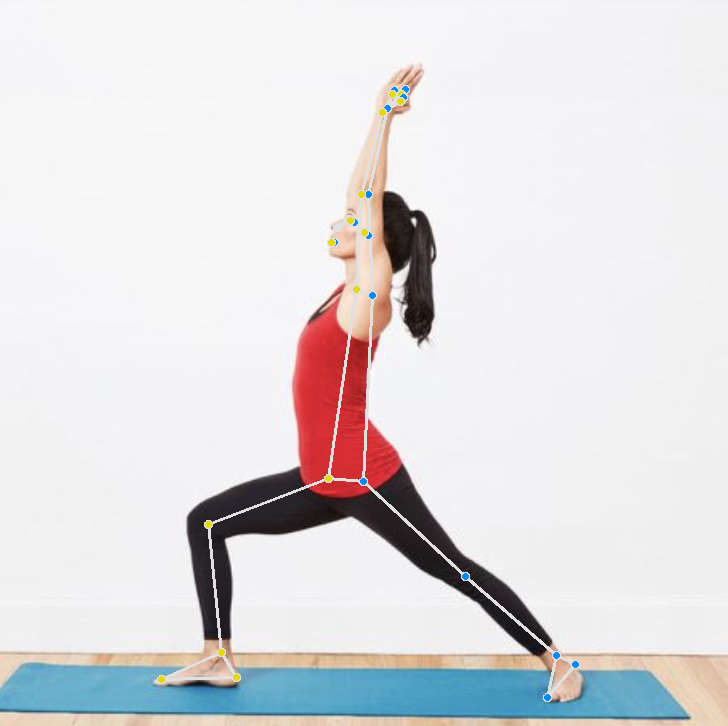











Cropped Image


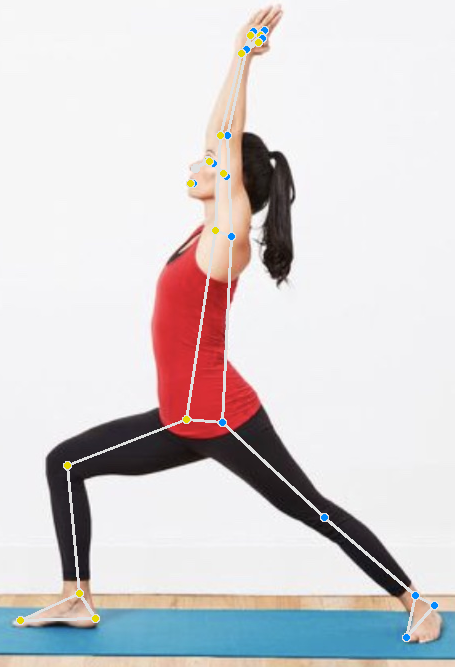











Resized Image


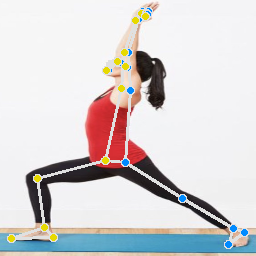

[x: 0.43067896366119385
 y: 0.2523877024650574
 visibility: 0.988860547542572,
 x: 0.4597276449203491
 y: 0.24214506149291992
 visibility: 0.992049515247345,
 x: 0.46417272090911865
 y: 0.24354492127895355
 visibility: 0.9903117418289185,
 x: 0.46876969933509827
 y: 0.24504509568214417
 visibility: 0.9924822449684143,
 x: 0.45599690079689026
 y: 0.24093715846538544
 visibility: 0.9926072359085083,
 x: 0.4577135741710663
 y: 0.2415936142206192
 visibility: 0.9926965236663818,
 x: 0.4597013294696808
 y: 0.24217361211776733
 visibility: 0.9951993823051453,
 x: 0.4986281991004944
 y: 0.2644285261631012
 visibility: 0.9951413869857788,
 x: 0.49085718393325806
 y: 0.26037028431892395
 visibility: 0.9918713569641113,
 x: 0.42529913783073425
 y: 0.2751880884170532
 visibility: 0.9864845871925354,
 x: 0.41761094331741333
 y: 0.27456071972846985
 visibility: 0.9853225946426392,
 x: 0.5089749693870544
 y: 0.3545938730239868
 visibility: 0.9994662404060364,
 x: 0.47405534982681274
 y: 0.3453130424

In [ ]:
annotate_image("./warrior_pose.jpg")

In [ ]:
for key in pose_info:
  line_1_point_1, line_1_point_2, line_2_point_1, line_2_point_2 = key.split()

  line_1_point_1 = " ".join(line_1_point_1.split("_"))
  line_1_point_2 = " ".join(line_1_point_2.split("_"))
  line_2_point_1 = " ".join(line_2_point_1.split("_"))
  line_2_point_2 = " ".join(line_2_point_2.split("_"))

  print(f"The angle between the line joining {line_1_point_1} and {line_1_point_2} and the line joining {line_2_point_1} and {line_2_point_2} is {180 - int(pose_info[key])} degrees")

The angle between the line joining right elbow and right wrist and the line joining right wrist and right index is 148 degrees
The angle between the line joining right elbow and right wrist and the line joining right wrist and right thumb is 138 degrees
The angle between the line joining right elbow and right wrist and the line joining right wrist and right pinky is 167 degrees
The angle between the line joining left hip and left knee and the line joining left knee and left ankle is 178 degrees
The angle between the line joining right ankle and right heel and the line joining right heel and right foot index is 60 degrees
The angle between the line joining left shoulder and left hip and the line joining left hip and left knee is 131 degrees
The angle between the line joining left shoulder and left hip and the line joining left hip and right hip is 89 degrees
The angle between the line joining left wrist and left pinky and the line joining left pinky and left index is 118 degrees
The ang

In [ ]:
pose_info_a = get_pose_info(test_image_landmarks)
pose_info_b = get_pose_info(normalised_landmarks_dict["3"])

In [ ]:
for key in pose_info_a.keys():
  print(key)

  print("Test Image", pose_info_a[key])
  print("Check Image", pose_info_b[key])

('right_elbow', 'right_wrist', 'right_wrist', 'right_index')
Test Image 61.465299864494284
Check Image 27.02519663118862
('right_elbow', 'right_wrist', 'right_wrist', 'right_thumb')
Test Image 70.07337184681236
Check Image 1.7526516148620646
('right_elbow', 'right_wrist', 'right_wrist', 'right_pinky')
Test Image 56.7844177055909
Check Image 42.16835479883118
('left_hip', 'left_knee', 'left_knee', 'left_ankle')
Test Image 6.883020567208812
Check Image 74.30956172328953
('right_ankle', 'right_heel', 'right_heel', 'right_foot_index')
Test Image 142.39166037453256
Check Image 125.93466828187846
('left_shoulder', 'left_hip', 'left_hip', 'left_knee')
Test Image 151.98962093620628
Check Image 120.50800499070834
('left_shoulder', 'left_hip', 'left_hip', 'right_hip')
Test Image 54.52957533349207
Check Image 54.92441726879061
('left_wrist', 'left_pinky', 'left_pinky', 'left_index')
Test Image 26.984367712325813
Check Image 111.74358543826611
('right_hip', 'right_knee', 'right_knee', 'right_ankle

In [ ]:
class KeyPoint:
  def __init__(self, x, y):
    self.x = x
    self.y = y

  def __repr__(self):
    return f"x: {self.x}, y: {self.y}"

  def to_numpy_arr(self):
    return np.array([self.x, self.y])

class Pose:
  def __init__(self, landmarks):
    self.keypoint_names = [
        "nose",
        "left_eye_inner",
        "left_eye",
        "left_eye_outer",
        "right_eye_inner",
        "right_eye",
        "right_eye_outer",
        "left_ear",
        "right_ear",
        "left_mouth",
        "right_mouth",
        "left_shoulder",
        "right_shoulder",
        "left_elbow",
        "right_elbow",
        "left_wrist",
        "right_wrist",
        "left_pinky",
        "right_pinky",
        "left_index",
        "right_index",
        "left_thumb",
        "right_thumb",
        "left_hip",
        "right_hip",
        "left_knee",
        "right_knee",
        "left_ankle",
        "right_ankle",
        "left_heel",
        "right_heel",
        "left_foot_index",
        "right_foot_index"
    ]

    for idx, landmark in enumerate(landmarks):
      setattr(self, self.keypoint_names[idx], KeyPoint(landmark.x, landmark.y))



In [ ]:
class GeometryHelper:

  def __init__(self):
    pass


  def find_angle(self, point1_line1, point2_line1, point1_line2, point2_line2):

    direction_vector_line1 = point2_line1 - point1_line1
    direction_vector_line2 = point2_line2 - point1_line2

    dot_product = np.dot(direction_vector_line1, direction_vector_line2)

    magnitude_line1 = np.linalg.norm(direction_vector_line1)
    magnitude_line2 = np.linalg.norm(direction_vector_line2)

    cosine_angle = dot_product / (magnitude_line1 * magnitude_line2)

    angle_radians = np.arccos(cosine_angle)
    angle_degrees = np.degrees(angle_radians)

    return angle_degrees

In [ ]:
pose = Pose(resized_landmarks)
geometry_helper = GeometryHelper()

In [ ]:
geometry_helper.find_angles(pose.right_hip.to_numpy_arr(), pose.right_knee.to_numpy_arr(), pose.right_knee.to_numpy_arr(), pose.right_ankle.to_numpy_arr())

0.19094021424480986

In [ ]:
key_point_names = [
        "nose",
        "left_eye_inner",
        "left_eye",
        "left_eye_outer",
        "right_eye_inner",
        "right_eye",
        "right_eye_outer",
        "left_ear",
        "right_ear",
        "left_mouth",
        "right_mouth",
        "left_shoulder",
        "right_shoulder",
        "left_elbow",
        "right_elbow",
        "left_wrist",
        "right_wrist",
        "left_pinky",
        "right_pinky",
        "left_index",
        "right_index",
        "left_thumb",
        "right_thumb",
        "left_hip",
        "right_hip",
        "left_knee",
        "right_knee",
        "left_ankle",
        "right_ankle",
        "left_heel",
        "right_heel",
        "left_foot_index",
        "right_foot_index"
    ]